# How much should properties be worth in Milwaukee, Wisconsin? (Part II)

## Goals

In the last few cases, we have seen several techniques used to diagnose the applicability of linear regression models. We have learned how to use indicators such as AIC to compare and detect overcomplicated models, how a proper study of the residuals can help to fit our models better, and how to extend the applicability of linear models with the use of variable transformations. The goal of this case is to learn a couple of tools that will help us further understand the applicability of our models better:

1. The use of test/training sets to evaluate the performance of our models
2. Detection of **multicolinearity** to improve numerical stability and increase the robustness of the predictive model

## Introduction

**Business Context.** You are the same property developer from the previous case, with the same goal. Although the previous model you built was a good start, it did not incorporate all the variables you wished to include, and you are skeptical of how well it might work on data that it was not trained on; i.e. **out-of-sample data**.

**Business Problem.** Your task is to **improve your model to predict property prices in the city of Milwaukee, Wisconsin**.

**Analytical Context.** Again, the dataset consists of property sales (commercial and residential) in Milwaukee, Wisconsin from 2002 to 2018. focused on diagnosing and fixing possible issues arising in linear regression. In the previous case, We learned how to visually analyze residuals and to detect outliers and heteroscedasticity. We showed that variable transformation can improve some of these issues, while explicit removal of outliers *explainable by external factors* could improve things further.

This case is structured as follows: you will 1) learn how categorical variables are actually handled in regression models; 2) dive into the predictive ability of the model and learn how to assess and improve it; and finally 3) look at **multicollinearity**, an issue that arises when fitting regression models with highly correlated or too many predictors and how to deal with it.

## Preparing our data

We will pick up were we left things off at the end of the last case. We will load the same packages and data, and fit the same model. The one difference is that we will remove from the dataset all properties with a sale price
below $2,000, which may not correspond to real market prices, per our analysis of residuals in the last exercise of the previous case:

In [1]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv("2002-2018-property-sales-data.csv",
    dtype = { # indicate categorical variables
        "PropType": "category",
        "District": "category",
        "Extwall": "category",
        "Nbhd": "category",
        "Style": "category",
    },
    parse_dates=["Sale_date"], # the Sale_date column is parsed as a date
)
def remove_unused_categories(data):
    """ The `remove_unused_categories` method in pandas
        removes categories from a Series if there are no
        elements of that category.
        
        This function is a convenience function that removes
        unused categories for all categorical columns
        of a data frame.
        
        The reason this is useful is that when we
        fit a linear regression, `statsmodels` will
        create a coefficient for every category in a column,
        and so unused categories pollute the results.
    """
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    (data["Sale_price"] > 2000) & # this is the only change!
    (data["Year_Built"] > 1800) &
    (data["Fin_sqft"] > 0) & # must have non-zero finished square feet
    (data["Lotsize"] > 0)  & # must have non-zero lot size
    (data["PropType"] == "Residential")
    )
data_clean = data.iloc[clean].copy()
remove_unused_categories(data_clean).head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
10,Residential,3080013000,3033 N 35TH ST,NaN,7,2960,AP 1,Frame,2.0,1913,0,3476,4,9,1,0,5040,2002-02-01,42000
51,Residential,3190434000,1908 E WEBSTER PL,NaN,3,3170,Rm or Rooming House,Frame,2.0,1897,0,1992,4,2,2,0,2880,2002-05-01,145000
67,Residential,3891722000,812 N 25TH ST,NaN,4,3040,Rm or Rooming House,Frame,2.0,1907,0,2339,6,0,1,0,3185,2002-06-01,30000
116,Residential,3880628000,959 N 34TH ST,NaN,4,2300,AP 1,Frame,2.0,1890,0,2329,4,4,1,0,5781,2002-10-01,66500
134,Residential,3880406000,3209 W WELLS ST,NaN,4,2300,Mansion,Stone,2.5,1891,0,7450,2,7,6,0,15600,2002-11-01,150500


## Training vs. test sets

As we discussed in the introduction, one of our chief concerns is whether or not the model we have built works just as well on out-of-sample data as it does on in-sample data. This is a *very* common problem in model-building, as is known as **overfitting**. You will learn more about overfitting in future cases, but here we will discuss a simple method for mitigating it.

The idea is to randomly split the data into a training set and a test set. The **training set** is the one on which we train and fit our multiple linear regression model. We then run our fitted model on the **test set** and compared its predictions against the actual test set response variable data to evaluate its performance.

### Exercise 1:

Write code to split the data into training and test sets (an 80-20 split is a good starting point). Fit a linear regression model on the training set, with the logarithm of `Sale_price` as the response variable and `District`, `Units`, and the logarithm of `Fin_sqft` as the predictor variables.'

**Note:** In order to make the results reproducible, write ```np.random.seed(135568109)``` before your code.

**Answer.**

First we set the random seed, which ensures that everyone who runs this notebook will get the same random numbers, and therefore the same results in the proceeding analysis. We then randomly choose 80% of the indices between 1 and the number of rows in the data. Extracting these rows from the data yields the training set, while all other rows form the test set:

In [3]:
np.random.seed(135568109) # a seed makes the analysis reproducible
                     # so everyone will get the same results
ndata = len(data_clean)
# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(ndata),int(0.8*ndata),replace=False)
# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(ndata)) - set(idx_train)))
train     = data_clean.iloc[idx_train] # the training data set
test      = data_clean.iloc[idx_test]  # the test data set
print(train.shape) # 19,312 rows and 19 columns
print(test.shape)  #  4,829 rows and 19 columns
model_log = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                           "+ np.log(Fin_sqft)", 
                 data = train).fit()
model_log.summary()

(19556, 19)
(4889, 19)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1886.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:10:27   Log-Likelihood:                -7612.5
No. Observations:               19556   AIC:                         1.526e+04
Df Residuals:                   19539   BIC:                         1.539e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2685      0.063     84.177      0.000       5.146       5.391
District[T.10]       0.6211      0.015     41.545      0.000       0.592       0.650
District[T.11]       0.8147      0.014     56.736      0.000       0.787       0.843
District[T.12]      -0.0125      0.023     -0.546      0.585      -0.057       0.032
District[T.13]       0.7995      0.015     53.747      0.000       0.770       0.829
District[T.14]       0.8624      0.015     58.160      0.000       0.833       0.891
District[T.15]      -0.4609      0.022    -21.077      0.000      -0.504      -0.418
District[T.2]        0.3029      0.017     18.298      0.000       0.270       0.335
District[T.3]        1.0236      0.017     60.776      0.000       0.991       1.057
District[T.4]       -0.2284      0.034     -6.670      0.000      -0.296      -0.161
District[T.5]        0.6830      0.014     47.556      0.000       0.655       0.711
District[T.6]       -0.1563      0.020     -7.799      0.000      -0.196      -0.117
District[T.7]       -0.0693      0.018     -3.896      0.000      -0.104      -0.034
District[T.8]        0.1562      0.019      8.136      0.000       0.119       0.194
District[T.9]        0.5684      0.017     32.742      0.000       0.534       0.602
Units               -0.3476      0.007    -50.168      0.000      -0.361      -0.334
np.log(Fin_sqft)     0.8642      0.009     94.900      0.000       0.846       0.882
==============================================================================
Omnibus:                     4417.978   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26736.926
Skew:                          -0.949   Prob(JB):                         0.00
Kurtosis:                       8.405   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Categorical features under the hood

You may have noticed that there are over a dozen coefficients for `District` above. This is because `District` is a categorical variable, and for categorical features, one coefficient is obtained for all but one of the categories. If there are only two categories (e.g. gender), this is intuitive: the feature is converted into a column of zeros and ones before feeding it into the regression, where it is treated like a regular numerical variable.

When there are more than two categories, one category is designated the “reference” or “baseline” category, and “dummy” columns of ones and zeros are created for all other categories. Let's take a dummy example with three categories and five rows:

| Category        |
|--------------|
| A            |
| B            |
| C            |
| C            |
| A            |

Before the linear regression is fitted, the `Category` column is transformed into **two** “dummy” columns (a column for baseline category is not added).

The first column is 1 if the district is `B`, and 0 otherwise, whereas the second column is 1 if the district is `C`, and 0 otherwise.  We get:

| Category_B            | Category_C           |
|--------------|-------------|
| 0            | 0           |
| 1            | 0           |
| 0            | 1           |
| 0            | 1           |
| 0            | 0           |

The dummy columns are fed into the linear regression and treated like regular numerical variables. This technique is called **one-hot encoding** and can be done manually with the pandas function `pd.get_dummies()`:

In [4]:
df_dummy=pd.DataFrame({'Category':['A','B','C','C','A']})
pd.get_dummies(df_dummy,columns=['Category'], drop_first=True) #Use drop_first to drop the first category

,Category_B,Category_C
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


Just like in the binary case, the choice of baseline changes the coefficients and their interpretation; the `District[T.3]` coefficient of 1.0236 should be interpreted as the difference in predicted outcomes between districts 3 and 1. But the baseline choice does not affect predictions and model performance, which is why most software will arbitrarily pick one category as the baseline without warning (often the first alphabetically).

### Exercise 2:

#### 2.1

Add `Style` to our last regression model. Do this in two ways: first by transforming the `Style` variable using `pd.get_dummies()` and then without the transformation. Verify that you obtain the same results. According to this model, which property style is the most desirable?

**Hint:** The `Style` variable contains names, like `Residence O/S`, which may be problematic when writing `smf.ols` formulas (see the [Pasty Syntax](https://patsy.readthedocs.io/en/latest/index.html)). You can use the `pasty` quote `Q()` syntax on variable names to avoid this issue:
```
formula="np.log(Sale_price) ~Q("Residence O/S")+...
```

In [5]:
#Store the syles and sort them.
Styles=list(train['Style'].unique())
Styles.sort() #Just to keep track of the baseline category.
train_dummy=pd.get_dummies(train,columns=['Style'],prefix='',prefix_sep='',drop_first=True)
#Write down the regression formula
formula0="np.log(Sale_price) ~ "
for style in Styles[1:]:
    formula0+='Q("'+style+'")+'
formula0=formula0+'District + Units+ np.log(Fin_sqft)'
#Create the model
model_style_1 = smf.ols(formula = formula0, 
                 data = train_dummy).fit()
model_style_1.summary()
model_style = smf.ols(formula = "np.log(Sale_price) ~ Style + District + Units"
                           "+ np.log(Fin_sqft)", 
                 data = train).fit()
model_style.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1034.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:10:35   Log-Likelihood:                -6859.4
No. Observations:               19556   AIC:                         1.379e+04
Df Residuals:                   19522   BIC:                         1.405e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.4606      0.165     27.093      0.000       4.138       4.783
Style[T.Bi-Level]                0.1548      0.130      1.195      0.232      -0.099       0.409
Style[T.Cape Cod]                0.2740      0.121      2.260      0.024       0.036       0.512
Style[T.Colonial]                0.3373      0.121      2.778      0.005       0.099       0.575
Style[T.Cottage]                -0.0194      0.122     -0.159      0.874      -0.259       0.220
Style[T.Dplx Bungalow]          -0.1922      0.101     -1.911      0.056      -0.389       0.005
Style[T.Duplex N/S]             -0.0573      0.101     -0.568      0.570      -0.255       0.140
Style[T.Duplex O/S]             -0.2727      0.100     -2.717      0.007      -0.469      -0.076
Style[T.Duplex-Cottage]         -0.4176      0.105     -3.994      0.000      -0.623      -0.213
Style[T.Mansion]                 0.3672      0.128      2.876      0.004       0.117       0.617
Style[T.Milwaukee Bungalow]      0.1290      0.121      1.064      0.288      -0.109       0.367
Style[T.Ranch]                   0.3379      0.121      2.786      0.005       0.100       0.576
Style[T.Residence O/S]           0.0998      0.121      0.824      0.410      -0.138       0.337
Style[T.Rm or Rooming House]    -0.2441      0.155     -1.577      0.115      -0.547       0.059
Style[T.Split Level]             0.1984      0.125      1.586      0.113      -0.047       0.444
Style[T.Townhouse]              -0.0811      0.104     -0.782      0.434      -0.284       0.122
Style[T.Triplex]                -0.2118      0.089     -2.392      0.017      -0.385      -0.038
Style[T.Tudor]                   0.3637      0.124      2.941      0.003       0.121       0.606
District[T.10]                   0.6678      0.015     45.862      0.000       0.639       0.696
District[T.11]                   0.7631      0.014     54.638      0.000       0.736       0.790
District[T.12]                   0.1575      0.023      6.765      0.000       0.112       0.203
District[T.13]                   0.7626      0.014     52.997      0.000       0.734       0.791
District[T.14]                   0.9436      0.015     64.681      0.000       0.915       0.972
District[T.15]                  -0.3656      0.021    -17.020      0.000      -0.408      -0.323
District[T.2]                    0.2498      0.016     15.489      0.000       0.218       0.281
District[T.3]                    1.1182      0.017     65.617      0.000       1.085       1.152
District[T.4]                   -0.1705      0.034     -5.076      0.000      -0.236      -0.105
District[T.5]                    0.6298      0.014     44.992      0.000       0.602       0.657
District[T.6]                   -0.0181      0.020     -0.905      0.365    

**Answer.**

The mansion style is the most desirable according to this model, since it has the highest positive coefficient.

----------

#### 2.2

In the model below, we have *not* removed the baseline category after using ```get_dummies()```. Is this model correct? Why or why not? 

In [6]:
train_dummy2=pd.get_dummies(train,columns=['Style'],prefix='',prefix_sep='')
formula1="np.log(Sale_price) ~ "
for style in Styles:
    formula1+='Q("'+style+'")+'
formula1=formula1+'District + Units+ np.log(Fin_sqft)'

#Create the model
model_style_2 = smf.ols(formula = formula1, 
                 data = train_dummy2).fit()
model_style_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1034.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:10:40   Log-Likelihood:                -6859.4
No. Observations:               19556   AIC:                         1.379e+04
Df Residuals:                   19522   BIC:                         1.405e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.2662      0.091     46.820      0.000       4.088       4.445
District[T.10]               0.6678      0.015     45.862      0.000       0.639       0.696
District[T.11]               0.7631      0.014     54.638      0.000       0.736       0.790
District[T.12]               0.1575      0.023      6.765      0.000       0.112       0.203
District[T.13]               0.7626      0.014     52.997      0.000       0.734       0.791
District[T.14]               0.9436      0.015     64.681      0.000       0.915       0.972
District[T.15]              -0.3656      0.021    -17.020      0.000      -0.408      -0.323
District[T.2]                0.2498      0.016     15.489      0.000       0.218       0.281
District[T.3]                1.1182      0.017     65.617      0.000       1.085       1.152
District[T.4]               -0.1705      0.034     -5.076      0.000      -0.236      -0.105
District[T.5]                0.6298      0.014     44.992      0.000       0.602       0.657
District[T.6]               -0.0181      0.020     -0.905      0.365      -0.057       0.021
District[T.7]               -0.0396      0.017     -2.301      0.021      -0.073      -0.006
District[T.8]                0.2950      0.019     15.374      0.000       0.257       0.333
District[T.9]                0.4967      0.017     29.090      0.000       0.463       0.530
Q("AP 1")                    0.1945      0.102      1.914      0.056      -0.005       0.394
Q("Bi-Level")                0.3493      0.051      6.912      0.000       0.250       0.448
Q("Cape Cod")                0.4685      0.026     18.146      0.000       0.418       0.519
Q("Colonial")                0.5317      0.027     19.597      0.000       0.479       0.585
Q("Cottage")                 0.1750      0.030      5.762      0.000       0.115       0.235
Q("Dplx Bungalow")           0.0023      0.016      0.140      0.889      -0.030       0.035
Q("Duplex N/S")              0.1372      0.017      8.183      0.000       0.104       0.170
Q("Duplex O/S")             -0.0782      0.016     -5.029      0.000      -0.109      -0.048
Q("Duplex-Cottage")         -0.2232      0.031     -7.177      0.000      -0.284      -0.162
Q("Mansion")                 0.5616      0.052     10.810      0.000       0.460       0.663
Q("Milwaukee Bungalow")      0.3235      0.027     12.142      0.000       0.271       0.376
Q("Ranch")                   0.5324      0.026     20.685      0.000       0.482       0.583
Q("Residence O/S")           0.2942      0.026     11.252      0.000       0.243       0.345
Q("Rm or Rooming House")    -0.0496      0.178     -0.280      0.780      -0.398       0.298
Q("Split Level")             0.3929      0.039      9.988      0.000       0.316       0.470
Q("Townhouse")

In [7]:
train_dummy2=pd.get_dummies(train,columns=['Style'],prefix='',prefix_sep='')
formula1="np.log(Sale_price) ~ "
for style in Styles:  #here we are preventing to drop the baseline covariate
    formula1+='Q("'+style+'")+'
formula1=formula1+'District + Units+ np.log(Fin_sqft)'
#Create the model
model_style_2 = smf.ols(formula = formula1, 
                 data = train_dummy2).fit()
model_style_2.summary()
df_coeff=pd.merge(model_style_1.params.reset_index(),model_style_2.params.reset_index(),on='index',how='outer')
df_coeff=df_coeff.rename(columns={'index':'Coefficient','0_x':'Without baseline', '0_y':'With baseline'})
df_coeff['Error']=df_coeff['With baseline']-df_coeff['Without baseline']
df_coeff

,Coefficient,Without baseline,With baseline,Error
0,Intercept,4.460639,4.266184,-1.944548e-01
1,District[T.10],0.667837,0.667837,2.664535e-15
2,District[T.11],0.763087,0.763087,3.441691e-15
3,District[T.12],0.157484,0.157484,4.329870e-15
4,District[T.13],0.762585,0.762585,8.881784e-16
5,District[T.14],0.943554,0.943554,8.881784e-15
6,District[T.15],-0.365592,-0.365592,7.327472e-15
7,District[T.2],0.249833,0.249833,3.247402e-15
8,District[T.3],1.118158,1.118158,5.107026e-15
9,District[T.4],-0.170477,-0.170477,4.940492e-15


**Answer.**

We see that the coefficients of model_style_1 are essentially obtained from the coefficients of model_style_2 after subtracting 0.194455, the coefficient of the baseline category Q("AP 1"), from the rest of the coefficient corresponding to the Style variable. Thus, the two models are essentially the same.
However, incorporating the baseline category in the model adds redundancy: if we know the values of all the Style dummy variables except for Q("AP 1"), we will know the value of the dummy variable corresponding to Q("AP 1"). These redundancies often creates numerical problems, which may cause our models to behave badly (notice that the second Warning in this last summary did not appear in previous ones). This is an example of multicolinearity, which we will discuss later in the case.

----------

## Evaluating predictive performance

Recall that for any given data point, the residual is the difference between our model's prediction for that point and the actual value of that point. The **mean absolute error (MAE)** is a metric which summarizes the model's holistic performance on the entire dataset. The MAE is calculated by taking the absolute value of each residual, then taking the mean of all of those absolute values. In essence, the MAE describes the typical magnitude of the residuals; the lower the MAE, the better.

In [8]:
def MAE(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                    )
                )

print("MAE between model_log and log of true Sale price:",MAE(model_log.predict(test) ,np.log(test.Sale_price)))
print("MAE between exp(model_log) and true Sale price:",MAE(np.exp(model_log.predict(test)) ,test.Sale_price))

MAE between model_log and log of true Sale price: 0.2543504772499543
MAE between exp(model_log) and true Sale price: 29693.107359666494


Another very popular choice for evaluating regression is the **root mean squared error (RMSE)**. This is computed by taking the square of each residual, averaging them, and then taking the square root. Below is the implementation in python, which is possibly easier to understand than the above explanation:

In [9]:
def RMSE(prediction,true_values):
    
    return np.sqrt(                                                          # Root
            np.mean(                                                      # Mean
                np.square(                                                # Squared
                         prediction-true_values                           # Error
                )
            )
        )
        
print("RMSE between model_log and log of true Sale price:", RMSE(model_log.predict(test) ,np.log(test.Sale_price)))
print("RMSE between exp(model_log) and true Sale price:",RMSE(np.exp(model_log.predict(test)) ,test.Sale_price))

RMSE between model_log and log of true Sale price: 0.3668708311367413
RMSE between exp(model_log) and true Sale price: 43035.68438059336


Finally, there is the **mean absolute percentage error**. This takes the absolute value of each residual and divides it by the actual value of that point to obtain a percentage, then averaging across all percentages.

In [10]:
def MAPE(prediction,true_value):
    return np.mean(                                           # Mean
        np.abs(                                               # Absolute
               (prediction-true_value)/true_value             # Error
            )*100                                            # Percentage
    )

print("MAPE between model_log and log of true Sale price:", MAPE(model_log.predict(test) ,np.log(test.Sale_price)))
print("MAPE between exp(model_log) and true Sale price:", MAPE(np.exp(model_log.predict(test)) ,test.Sale_price))

MAPE between model_log and log of true Sale price: 2.2448463666728267
MAPE between exp(model_log) and true Sale price: 30.010358445800634


### Question:

Why would we not just use MAE instead of having to deal with three different metrics?

Although RMSE may seem needlessly complicated compared to MAE, it is much more commonly used. The reason is that the RMSE metric is the same as the one being minimized on the training data by a standard linear regression model (also called an **ordinary least squares (OLS)** regression). This makes it a “natural” choice using the same metric to evaluate the out-of-sample (test) performance.

Furthermore, the RMSE puts much more weight on outliers, since the errors are squared before being averaged. In cases where outliers are especially bad and need to be punished, the RMSE is a better choice.

The MAPE has a nice interpretation in that we can say that a model's predictions are on average wrong by a certain percentage. For example, our house price model could be on average off by 30%. Such a model is often described as being "70% accurate".

For those who are mathematically inclined, the equations below define the three error metrics above:

\begin{eqnarray*}
    MAE &= \frac{1}{n} \sum_{i=1}^n \left| y_i - \hat{y}_i \right| \\
    RMSE &= \sqrt{ \frac{1}{n} \sum_{i=1}^n ( y_i - \hat{y}_i )^2 } \\
    MAPE &= 100\% \frac{1}{n} \sum_{i=1}^n \left|\frac{ y_i - \hat{y}_i}{y_i} \right|
\end{eqnarray*}

### Exercise 3:

#### 3.1 

Compute the MAE, RMSE and MAPE for the linear model 
``` 
"Sale_price ~ District + Units+ Fin_sqft"
```
How does this model compares to ```model_log```?

In [11]:
model_lin = smf.ols(formula = "Sale_price ~ District + Units"
                           "+ Fin_sqft", 
                 data = train).fit()
model_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     2522.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:10:54   Log-Likelihood:            -2.3898e+05
No. Observations:               19556   AIC:                         4.780e+05
Df Residuals:                   19539   BIC:                         4.781e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.111e+04   2037.224     10.361      0.000    1.71e+04    2.51e+04
District[T.10]  4.993e+04   2053.420     24.318      0.000    4.59e+04     5.4e+04
District[T.11]  7.286e+04   1974.069     36.908      0.000     6.9e+04    7.67e+04
District[T.12] -3327.9414   3134.914     -1.062      0.288   -9472.640    2816.758
District[T.13]  7.162e+04   2044.727     35.025      0.000    6.76e+04    7.56e+04
District[T.14]  8.781e+04   2037.479     43.097      0.000    8.38e+04    9.18e+04
District[T.15] -4.997e+04   3003.689    -16.638      0.000   -5.59e+04   -4.41e+04
District[T.2]   1.867e+04   2275.581      8.206      0.000    1.42e+04    2.31e+04
District[T.3]   1.401e+05   2336.647     59.938      0.000    1.35e+05    1.45e+05
District[T.4]  -6.818e+04   4719.596    -14.446      0.000   -7.74e+04   -5.89e+04
District[T.5]   5.548e+04   1973.580     28.113      0.000    5.16e+04    5.94e+04
District[T.6]  -5797.9472   2753.277     -2.106      0.035   -1.12e+04    -401.289
District[T.7]  -1.421e+04   2442.523     -5.817      0.000    -1.9e+04   -9420.894
District[T.8]  -1088.2739   2637.765     -0.413      0.680   -6258.519    4081.971
District[T.9]   4.206e+04   2385.842     17.629      0.000    3.74e+04    4.67e+04
Units          -6.999e+04    943.776    -74.160      0.000   -7.18e+04   -6.81e+04
Fin_sqft          99.1541      0.723    137.224      0.000      97.738     100.570
==============================================================================
Omnibus:                    14105.557   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1397399.716
Skew:                           2.710   Prob(JB):                         0.00
Kurtosis:                      44.056   Cond. No.                     3.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
def MAE(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                    )
                )

print("MAE between model_lin and True Sale price:",MAE(model_lin.predict(test) ,test.Sale_price))

MAE between model_lin and True Sale price: 31402.403269020717


In [13]:
model_lin = smf.ols(formula = "Sale_price ~ District + Units+ Fin_sqft", 
                 data = train).fit()
print("MAE between predictions of model_lin and true sale price:", MAE(model_lin.predict(test),test.Sale_price))
print("MAE between exp(model_log) and true Sale price:", MAE(np.exp(model_log.predict(test)) ,test.Sale_price))
print('----------------------')
print("RMSE between predictions of model_lin and true sale price:", RMSE(model_lin.predict(test),test.Sale_price))
print("RMSE between exp(model_log) and true Sale price:", RMSE(np.exp(model_log.predict(test)) ,test.Sale_price))
print('----------------------')
print("MAPE between predictions of model_lin and true sale price:", MAPE(model_lin.predict(test),test.Sale_price))
print("MAPE between exp(model_log) and true Sale price:", MAPE(np.exp(model_log.predict(test)) ,test.Sale_price))

MAE between predictions of model_lin and true sale price: 31402.403269020717
MAE between exp(model_log) and true Sale price: 29693.107359666494
----------------------
RMSE between predictions of model_lin and true sale price: 44924.10834809467
RMSE between exp(model_log) and true Sale price: 43035.68438059336
----------------------
MAPE between predictions of model_lin and true sale price: 34.09145138669357
MAPE between exp(model_log) and true Sale price: 30.010358445800634


**Answer.**

The log model seems to do a much better job with predictions! Notice that we needed to exponentiate predictions given by model_log in order to be able to compare the performance of the two models.

----------

#### 3.2

Let us illustrate the differences between MAE, RMSE and MAPE with an example. In the following data, our test sample has been contaminated with a single outlier. Compare the MAE, RMSE and MAPE of the models:
```
model1: y~x
model2: y~(7.8182)x-24.3557
```
Use the test data ```x_test, y_test``` provided below. What do you see? Which model is better?

Text(0.5, 1.0, 'Test Data')

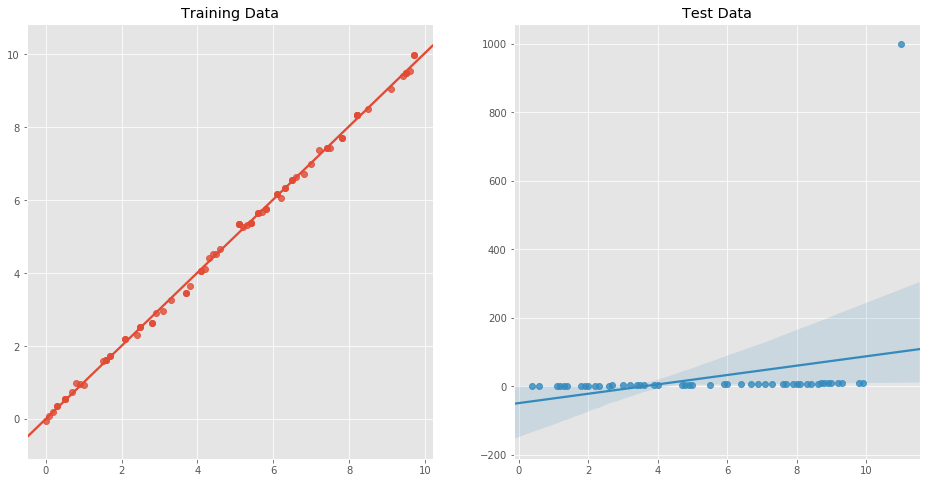

In [14]:
np.random.seed(135568109)
error=np.random.normal(0,0.1,100)
x_data=np.arange(0,10,0.1)
y_data=x_data+error

#Split the data into training and test data:
train_ex=np.random.randint(0,99,80)
x_train=x_data[train_ex]
y_train=y_data[train_ex]

test_ex=list(set(range(100))-set(train_ex))
x_test=x_data[test_ex]
y_test=y_data[test_ex]

#oops it got contaminated
x_test=np.append(x_test,11)
y_test=np.append(y_test,1000)


fig, axes=plt.subplots(nrows=1, ncols=2,figsize=(16,8))
sns.regplot(x=x_train, y=y_train,ax=axes[0])
axes[0].set_title('Training Data')

sns.regplot(x=x_test, y=y_test,ax=axes[1])
axes[1].set_title('Test Data')

In [15]:
model1_pred=x_test
model2_pred=(7.8182)*x_test-24.3557
print("MAE of model1:", MAE(model1_pred,y_test))
print("MAE of model2:", MAE(model2_pred,y_test))
print('----------------------')
print("RMSE of model1:", RMSE(model1_pred,y_test))
print("RMSE of model2:", RMSE(model2_pred,y_test))
print('----------------------')
print("MAPE of model1:", MAPE(model1_pred,y_test))
print("MAPE of model2:", MAPE(model2_pred,y_test))

MAE of model1: 20.26987875709878
MAE of model2: 38.13719655839178
----------------------
RMSE of model1: 141.28575611674023
RMSE of model2: 135.984270646776
----------------------
MAPE of model1: 4.589993854029356
MAPE of model2: 513.2308670735728


**Answer.**

MAE and MAPE are in favor of model1, whereas RMSE is in favor of model2! Notice how a single outlier can impose a threat to our models. If we remove the clear outlier from the dataset we obtain:

We can clearly see that model1 fits the data much better. Notice how robust MAPE was against outliers - the values did not change much here.

## Adding additional predictors to improve our model

Consider now `model_feat` described below. This model adds features for the number of stories and bedrooms, the year built, neighborhood (instead of simply district), type of external wall, number of full and half baths, lot size and sale year. This last predictor is an example of **feature engineering** – remember we are not limited to the predictors as they are given to us in the raw data. Often, it is beneficial to transform and combine predictors, as we did here by extracting the year from the sale date and treating it as a categorical variable.

### Exercise 4:

#### 4.1

Fit a linear regression of the logarithm of the sale price with the following features:

1. number of stories
2. number of bedrooms
3. number of units in the property
4. neighborhood code
5. style
6. type of external wall
7. number of full baths
8. number of half baths
9. the logarithm of square footage
10. the logarithm of the lot size
11. year the property was *built* as a *numerical* variable
12. year the property was *sold* as a *categorical* variable

Give the resulting fitted model the variable name `model_feat`.

**Hint:**

1) write a function to extract the year from the sale date – `train.Sale_date.iloc[0].year` gives the year of the first sale; 

2) [use `C()` around a term in the formula to make the term categorical](https://patsy.readthedocs.io/en/latest/categorical-coding.html))

In [16]:
def year_from_date(dt):
    """ function to extract the year from a Sale date """ 
    return dt.dt.year
model_feat = smf.ols(formula = "np.log(Sale_price) ~ "
                           "Stories + Year_Built + Nbhd"
                           "+ np.log(Fin_sqft)"
                           "+ Style"
                           "+ Extwall  + Units + Bdrms"
                           "+ Fbath + Hbath + np.log(Lotsize)"
                           "+ C(year_from_date(Sale_date))", 
                 data = train).fit()
model_feat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     441.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:11:15   Log-Likelihood:                -429.34
No. Observations:               19556   AIC:                             1239.
Df Residuals:                   19366   BIC:                             2736.
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.8451      0.377      2.239      0.025       0.105       1.585
Nbhd[T.1040]                             0.2735      0.036      7.594      0.000       0.203       0.344
Nbhd[T.1140]                            -0.3293      0.036     -9.255      0.000      -0.399      -0.260
Nbhd[T.1150]                            -0.4245      0.041    -10.434      0.000      -0.504      -0.345
Nbhd[T.1160]                            -0.4544      0.046     -9.944      0.000      -0.544      -0.365
Nbhd[T.1200]                            -0.0345      0.045     -0.769      0.442      -0.123       0.054
Nbhd[T.1220]                             0.4097      0.050      8.234      0.000       0.312       0.507
Nbhd[T.1340]                            -0.3873      0.042     -9.227      0.000      -0.470      -0.305
Nbhd[T.1380]                            -0.0072      0.040     -0.181      0.856      -0.085       0.070
Nbhd[T.1400]                             0.1177      0.036      3.263      0.001       0.047       0.188
Nbhd[T.1440]                            -0.5273      0.042    -12.566      0.000      -0.610      -0.445
Nbhd[T.1460]                             0.2890      0.035      8.282      0.000       0.221       0.357
Nbhd[T.1470]                             0.2037      0.036      5.700      0.000       0.134       0.274
Nbhd[T.1480]                             0.0524      0.036      1.474      0.140      -0.017       0.122
Nbhd[T.1490]                             0.0611      0.037      1.631      0.103      -0.012       0.135
Nbhd[T.1500]                            -0.5261      0.051    -10.386      0.000      -0.625      -0.427
Nbhd[T.1560]                            -0.1203      0.048     -2.526      0.012      -0.214      -0.027
Nbhd[T.1620]                            -0.2967      0.040     -7.381      0.000      -0.376      -0.218
Nbhd[T.1680]                            -0.3366      0.041     -8.202      0.000      -0.417      -0.256
Nbhd[T.1740]                            -0.2844      0.043     -6.601      0.000      -0.369      -0.200
Nbhd[T.1780]                            -0.4845      0.046    -10.516      0.000      -0.575      -0.394
Nbhd[T.1820]                            -0.0756      0.043     -1.740      0.082      -0.161       0.010
Nbhd[T.1830]                             0.0778      0.041      1.905      0.057      -0.002       0.158
Nbhd[T.1840]                             0.1465      0.042      3.505      0.000       0.065       0.228
Nbhd[T.1850]                             0.1892      0.039      4.863      0.000       0.113       0.266
Nbhd[T.1860]                            -0.1243      0.042     -2.995      0.003      -0.206      -0.043
Nbhd[T.1870]                          

**Answer.**

----------

#### 4.2

How should the coefficient `Extwall[T.Brick]` of 0.0236 be interpreted? Select the appropriate choice below:

"A property with brick external walls is predicted to have a log price that is..."

(a) 0.0236 higher than a property with aluminum / vinyl external walls that is otherwise identical

(b) increased by 0.0236, all else being equal

(c) 0.0236 higher than the average property in the training dataset

**Answer.**

(a) is the correct interpretation of the coefficient. Categorical coefficients in a linear regression are always interpreted relative to the reference category, which by default is the first category alphabetically, in this case “Aluminum / Vinyl”.

----------

#### 4.3

Compute the mean absolute error for `model_feat`, and compare it to `model_log`. Does `model_feat` perform better or worse? What about the $R^2$ and AIC of these two models?

In [17]:
print("MAE of model_feat:",MAE(np.exp(model_feat.predict(test)),test.Sale_price))
print("R2 of model_feat:",model_feat.rsquared)
print("AIC of model_feat:",model_feat.aic)
print("MAE of model_log:",MAE(np.exp(model_log.predict(test)),test.Sale_price))
print("R2 of model_log:",model_log.rsquared)
print("AIC of model_log:",model_log.aic)

MAE of model_feat: 20297.09339946551
R2 of model_feat: 0.8114560847210258
AIC of model_feat: 1238.67453738732
MAE of model_log: 29693.107359666494
R2 of model_log: 0.6069441786753875
AIC of model_log: 15258.916725997988


**Answer.** 

We see that the MAE and 𝑅2 of model_feat are much better. Moreover, the AIC of model_feat has decreased as well! This indicates that model_feat is preferable than model_log.

----------

#### 4.4
What story does this model tell us about the Milwaukee housing market during the last 15 years?

(a) The prices increased until 2007, when there was a housing crash. Since then, prices have gone back up to their pre-crash level

(b) Overall, housing prices steadily increased over time

(c) The prices increased until 2007, then subsequently went down

(d) The prices increased until 2007, when there was a housing crash. Since then, prices have slowly risen, but they have not yet fully recovered

**Answer.**

(d). The coefficient for 2018 is still lower than 2006 and 2008. This can also be seen from the plot of coefficients below:

Text(0, 0.5, 'Coefficient')

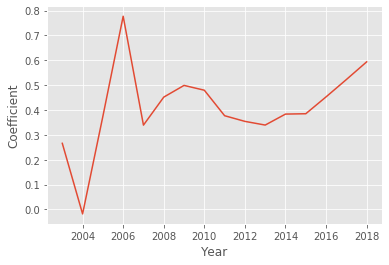

In [18]:
year = range(2003,2019)
year_coef = model_feat.params["C(year_from_date(Sale_date))[T.2003]":"C(year_from_date(Sale_date))[T.2018]"]
plt.plot(year, year_coef)
plt.xlabel("Year")
plt.ylabel("Coefficient")

#### 4.5

A 2-story townhouse is on the market for $150,000 with the following characteristics:

1. Neighborhood 4320 in District 11
2. 1200 finished square feet
3. 7200 square feet lot size
4. 3 bedrooms
5. Vinyl external wall
6. built in 1987
7. 1 full bath and 1 half-bath
8. 1 unit

Is this a good price according to our model? What assumptions do you have to make to answer this question?

**Answer.**

Our model predicts (see below) that this house should sell for about $130,000. Therefore $150,000 is too high of a price unless the house has positive features that are not captured in the data.
One factor that we did not account for is that the sale took place in 2019. Since we have no 2019 data, we had to assume that prices remained flat after 2018. It is possible that real estate prices have gone up significantly in 2019, which could justify the $150,000 asking price.

In [19]:
d = {"Stories": 2,
     "Style": "Townhouse",
     "Extwall": "Aluminum / Vinyl",
     "Nbhd": '4320',
     "Fin_sqft": 1200.0,
     "Lotsize": 7200.0,
     "Sale_date": pd.datetime(2018,10,1), # there is no training data for 2019, 
                                          # so we have to assume prices stayed flat
                                          # since 2018
     "Year_Built":  1987,
     "Fbath": 1,
     "Hbath": 1,
     "Units": 1,
     "Bdrms": 3}
d_df = test.copy()
d_df = d_df.append(d, ignore_index=True)
pred = model_feat.predict(d_df.iloc[-1:]).iloc[0]
print("This property is predicted to sell for ${:,.0f}.".format(np.exp(pred)))

This property is predicted to sell for $129,595.


----------

## Collinearity and standard errors

The model in the previous section seems to be a good step towards our main goal. However, from the last few cases we have learned that adding a large dump of new features to a model and then leaving it to its own devices is not a prudent strategy, because:

1. We do not want to include features that add little predictive power to our model. Otherwise, we may end up with an overcomplicated model. Remember that we generally want a model that achieves a good level of predictiveness without sacrificing simplicity
2. Adding too many features increases the danger of *overfitting*, thus decreasing the potential applicability of the model

So far, we have learned a couple of methods to alleviate these issues:

1. We can use indicators such as the ```AIC``` to detect if we are adding variables with little predictive power
2. We can divide our sample data into `Train/Test` sets and use the `Test` set, along with some measure like `RMSE`, to evaluate the applicability of our model

However, there exists a third potential issue whenever we add too many features to our models: 

3. Linear regression can actually be **destabilized** when there are too many predictors that do not add value

This means that small changes in the training data fed into the model results in large changes in the fitted coefficients; overfitting is a common consequence of this phenomenon.

### Question:

What do you think causes the above to happen?

As one adds more predictors, they begin to contribute redundant information (which explains why every additional predictor contributes zero marginal information). Mathematically, this means that new predictors can often be expressed to a good extent as linear combinations (weighted sums) of some of the other predictors. When this happens, a model is said to exhibit **collinearity** or **multicollinearity**.

Since predictors become mostly redundant, this means that nearly identical predictions can be obtained by vastly different coefficient values, by "trading off" between the coefficients of the predictors which exhibit collinearity.
Consequently, the model has no way to decide from the data alone which of these possible models with identical predictions to choose, which translates into inflated standard errors and a high risk of overfitting.

To demonstrate this effect, we will introduce an engineered feature: `log(Fin_sqft/Lotsize + 0.00001)`.
The small constant is there to avoid making the new feature *perfectly* collinear with log(`Fin_sqft`) and log(`Lotsize`) (which would create a "divide-by-zero" error in the background regression function code):

In [21]:
# base model without engineered collinear feature
model_finlot = smf.ols(formula = "np.log(Sale_price) ~ "
                           "Stories + Year_Built"
                           "+ np.log(Fin_sqft)"
                           "+ np.log(Lotsize)"
                           "+ Style"
                           "+ Extwall  + Units + Bdrms"
                           "+ Fbath + Hbath + Nbhd"
                           "+ C(year_from_date(Sale_date))", 
                 data = train).fit()
model_finlot.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     441.0
Date:                Sat, 04 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:14:44   Log-Likelihood:                -429.34
No. Observations:               19556   AIC:                             1239.
Df Residuals:                   19366   BIC:                             2736.
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.8451      0.377      2.239      0.025       0.105       1.585
Style[T.Bi-Level]                       -0.5602      0.126     -4.448      0.000      -0.807      -0.313
Style[T.Cape Cod]                       -0.4026      0.121     -3.323      0.001      -0.640      -0.165
Style[T.Colonial]                       -0.3724      0.121     -3.070      0.002      -0.610      -0.135
Style[T.Cottage]                        -0.5723      0.122     -4.710      0.000      -0.810      -0.334
Style[T.Dplx Bungalow]                  -0.5672      0.110     -5.154      0.000      -0.783      -0.352
Style[T.Duplex N/S]                     -0.5927      0.110     -5.371      0.000      -0.809      -0.376
Style[T.Duplex O/S]                     -0.6102      0.110     -5.557      0.000      -0.825      -0.395
Style[T.Duplex-Cottage]                 -0.7238      0.112     -6.457      0.000      -0.944      -0.504
Style[T.Mansion]                        -0.3674      0.125     -2.949      0.003      -0.612      -0.123
Style[T.Milwaukee Bungalow]             -0.3779      0.121     -3.121      0.002      -0.615      -0.141
Style[T.Ranch]                          -0.4036      0.121     -3.328      0.001      -0.641      -0.166
Style[T.Residence O/S]                  -0.4264      0.121     -3.527      0.000      -0.663      -0.189
Style[T.Rm or Rooming House]            -0.1702      0.123     -1.383      0.167      -0.411       0.071
Style[T.Split Level]                    -0.4746      0.123     -3.846      0.000      -0.716      -0.233
Style[T.Townhouse]                      -0.7465      0.112     -6.656      0.000      -0.966      -0.527
Style[T.Triplex]                        -0.6393      0.104     -6.128      0.000      -0.844      -0.435
Style[T.Tudor]                          -0.3378      0.123     -2.758      0.006      -0.578      -0.098
Extwall[T.Block]                        -0.0450      0.024     -1.905      0.057      -0.091       0.001
Extwall[T.Brick]                         0.0235      0.005      4.714      0.000       0.014       0.033
Extwall[T.Fiber-Cement]                  0.1403      0.026      5.297      0.000       0.088       0.192
Extwall[T.Frame]                        -0.0564      0.006     -9.023      0.000      -0.069      -0.044
Extwall[T.Masonry / Frame]               0.0027      0.011      0.241      0.810      -0.019       0.025
Extwall[T.Prem Wood]                     0.0521      0.036      1.438      0.150      -0.019       0.123
Extwall[T.Stone]                         0.0503      0.011      4.751      0.000       0.030       0.071
Extwall[T.Stucco]                       -0.0222      0.014     -1.595      0.111      -0.050       0.005
Nbhd[T.1040]                          

In [20]:
model_coll = smf.ols(formula = "np.log(Sale_price) ~ "
                           "Stories + Year_Built"
                           "+ np.log(Fin_sqft)"
                           "+ np.log(Lotsize)"
                           "+ np.log(Fin_sqft/Lotsize + 0.0001)"
                           "+ Style"
                           "+ Extwall  + Units + Bdrms"
                           "+ Fbath + Hbath"
                           "+ Nbhd"
                           "+ C(year_from_date(Sale_date))", 
                 data = train).fit()
model_coll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     439.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:11:44   Log-Likelihood:                -422.56
No. Observations:               19556   AIC:                             1227.
Df Residuals:                   19365   BIC:                             2732.
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.9217      0.378      2.439      0.015       0.181       1.662
Style[T.Bi-Level]                       -0.5621      0.126     -4.464      0.000      -0.809      -0.315
Style[T.Cape Cod]                       -0.4028      0.121     -3.326      0.001      -0.640      -0.165
Style[T.Colonial]                       -0.3758      0.121     -3.100      0.002      -0.614      -0.138
Style[T.Cottage]                        -0.5742      0.121     -4.727      0.000      -0.812      -0.336
Style[T.Dplx Bungalow]                  -0.5654      0.110     -5.139      0.000      -0.781      -0.350
Style[T.Duplex N/S]                     -0.5928      0.110     -5.374      0.000      -0.809      -0.377
Style[T.Duplex O/S]                     -0.6091      0.110     -5.549      0.000      -0.824      -0.394
Style[T.Duplex-Cottage]                 -0.7215      0.112     -6.438      0.000      -0.941      -0.502
Style[T.Mansion]                        -0.3694      0.125     -2.966      0.003      -0.614      -0.125
Style[T.Milwaukee Bungalow]             -0.3785      0.121     -3.127      0.002      -0.616      -0.141
Style[T.Ranch]                          -0.4026      0.121     -3.320      0.001      -0.640      -0.165
Style[T.Residence O/S]                  -0.4279      0.121     -3.541      0.000      -0.665      -0.191
Style[T.Rm or Rooming House]            -0.1715      0.123     -1.394      0.163      -0.413       0.070
Style[T.Split Level]                    -0.4766      0.123     -3.864      0.000      -0.718      -0.235
Style[T.Townhouse]                      -0.7495      0.112     -6.684      0.000      -0.969      -0.530
Style[T.Triplex]                        -0.6358      0.104     -6.095      0.000      -0.840      -0.431
Style[T.Tudor]                          -0.3369      0.122     -2.751      0.006      -0.577      -0.097
Extwall[T.Block]                        -0.0445      0.024     -1.884      0.060      -0.091       0.002
Extwall[T.Brick]                         0.0233      0.005      4.683      0.000       0.014       0.033
Extwall[T.Fiber-Cement]                  0.1417      0.026      5.350      0.000       0.090       0.194
Extwall[T.Frame]                        -0.0563      0.006     -9.001      0.000      -0.069      -0.044
Extwall[T.Masonry / Frame]               0.0038      0.011      0.339      0.735      -0.018       0.026
Extwall[T.Prem Wood]                     0.0526      0.036      1.454      0.146      -0.018       0.124
Extwall[T.Stone]                         0.0507      0.011      4.787      0.000       0.030       0.071
Extwall[T.Stucco]                       -0.0227      0.014     -1.633      0.102      -0.050       0.005
Nbhd[T.1040]                          

### Exercise 5:

#### 5.1

What happened to the coefficients and standard errors of `log(Fin_sqft)` and `log(Lotsize)` as the engineered feature was introduced?

**Answer.**

The coefficient of log(Fin_sqft) went up by a large number while the coeffient of log(Lotsize) went down by a similarly large number. The coefficient of log(Lotsize) is now an absurdly large negative number. The coefficients are destabilized, which is reflected in the much higher standard errors (which went from about 0.01 to 18).

#### 5.2: 

What happens when you change the 0.0001 constant (say, to 0.00001 or 0.001) in the engineered feature?

**Answer.**

As the constant grows, the collinearity weakens.

## Conclusions

In this case, we had a closer look at categorical predictors. We then focused on predictions, and discussed a few different metrics for the predictive power of a regression model. Each had their own advantages and disadvantages depending on what the business problem at hand needed to prioritize.

To improve the predictive power of our model, we added additional predictors. We learned how to **engineer features** to capture information that was not directly available as a column of the data set. However, we saw how adding so many features at once could lead to **collinearity** and therefore destabilize a model, making coefficients difficult to interpret and increasing the chance of overfit predictions in production.

## Takeaways

In this case, we have expanded our toolbox for the diagnosis of linear regression models. We have learned:
    
1. How the use of training/testing sets, along with measures such as MAE, MAPE and RMSE can help in evaluating the predictive power of linear models. We note that these tools are not only applicable to linear models, but also work with any other type of model and we will continue using them in future cases. 
2. How categorical variables are encoded in linear regression models.
3. That more complex models can provide better predictions, but this can destabilize performance. In many such situations, complexity creates multicollinearity between variables which actually makes our models highly unstable and prone to overfitting. 

Remember, much of the business world is about applying trained models on future, currently unknown data. Overfitting can lead to serious negative impacts on the bottom line.